# Into to Neural Networks & Deel Learning Residency-7 Project-2 - SVHN

Case Study Description: Steeet View House Number (SVHM)

SVHM is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirements on data formatting but comes from a sginificantly harder, unsolved, real world problem(recognizing digits and numbers in natural scene images. SVHM is obtained from house numbers in Google Street View images

The goal of this project is to take an image from SVHM dataset and determine what taht digit is. This is multiclass classification problem with 10 classes, one for each digit 0-9. Digit "1" has label 1, "9" has label 9 and "0" has label 10.

Although there are 6,00,000 images in this dataset, we have extracted 60,000 images(42,000 training and 18,000 test images) to do this project. Data comes in a MNIST like format of 32-by-32 RGB images centered around a single digit (many of the images do contains some distractors at the sides)

Dataset: SVHM_single_grey1.h5
the data is subset of original dataset

Project Objectives 

The objective of the project is to learn how to implement a simple image classification pipeline based on the k-Nearest Neighbour and a deep neural network. The goals of this assignment are as follows: 

1. Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages) 
2. Data fetching and understand the train/val/test splits. 
3. Implement and apply an optimal k-Nearest Neighbor (kNN) classifier (7.5 points) 
4. Print the classification metric report (2.5 points) 
5. Implement and apply a deep neural network classifier including (feedforward neural network, RELU activations) (5 points) 
6. Understand and be able to implement (vectorized) backpropagation (cost stochastic gradient descent, cross entropy loss, cost functions) (2.5 points) 
7. Implement batch normalization for training the neural network (2.5 points)
8. Understand the differences and trade-offs between traditional and NN classifiers with the help of classification metrics (5 points) 


In [1]:
# import all necessary packages
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import h5py

from scipy.stats import zscore
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import categorical_crossentropy

from keras.callbacks import TensorBoard
from time import time

Using TensorFlow backend.


### 1. Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages) 


### 2. Data fetching and understand the train/val/test splits.

In [2]:
# load the dataset
file = h5py.File("SVHN_single_grey1.h5")

In [3]:
list(file.keys())

['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']

In [4]:
# training data
X_train = np.array(file["X_train"])
y_train = np.array(file["y_train"])
print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)

X_train:  (42000, 32, 32)
y_train:  (42000,)


In [5]:
# Testing data
X_test = np.array(file["X_test"])
y_test = np.array(file["y_test"])
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

X_test:  (18000, 32, 32)
y_test:  (18000,)


In [6]:
file.close()

In [7]:
print(y_train.shape)
print('First 5 examples are: ', y_train[0:5])

(42000,)
First 5 examples are:  [2 6 7 4 4]


In [8]:
# dataset have 10 classes and each label is an integer between 1 and 10:
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=num_classes)

In [9]:
print(y_train_cat.shape)
print('First 5 examples are: ', y_train_cat[0:5])

(42000, 10)
First 5 examples are:  [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


***Visualize the data***: Plot first 10 images in the triaining set and their labels.

In [10]:
# This is multiclass classification problem with 10 classes, one for each digit 0-9. 
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

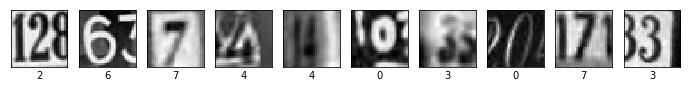

label for each of the above image: 
 [2, 6, 7, 4, 4, 0, 3, 0, 7, 3]


In [11]:
labelCode = []
plt.figure(figsize=(12,12))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(X_train[i], cmap='Greys') 
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    label = np.where(y_train_cat[i] == 1)[0][0]
    plt.xlabel(class_names[label])
    labelCode.append(label)
plt.show()

print("label for each of the above image: \n", labelCode)

**plotting how the classes are distributed**

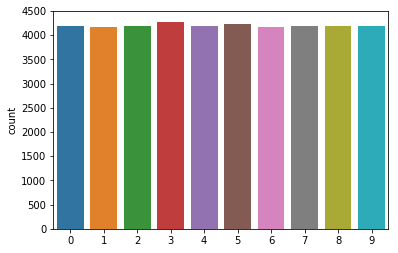

In [238]:
#plotting how the classes are distributed
sns.countplot(y_train)

### 3. Implement and apply an optimal k-Nearest Neighbor (kNN) classifier (7.5 points) 

***Iteration-1: Build KNN model without data normalization***

***Flat the input data***: Reshape train and test sets into shapes compatible with KNN model

In [12]:
# input image dimensions
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

In [13]:
# Flat the input data. image is of sise 32X32.. so flat each image to 1024
X_train_flat = np.reshape(X_train,(X_train.shape[0], img_rows*img_cols))
X_test_flat = np.reshape(X_test,(X_test.shape[0],img_rows*img_cols))

In [14]:
# input size
print("Train data Shape: ",X_train_flat.shape)
print("Test data Shape: ",X_test_flat.shape)

Train data Shape:  (42000, 1024)
Test data Shape:  (18000, 1024)


***Build and train using KNN clasifier***

In [15]:
# Call Nearest Neighbour algorithm
knn_model1 = KNeighborsClassifier(n_neighbors=5)
knn_model1.fit(X_train_flat, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

**Predict test data and get accuracy score and confusion matrix**

In [16]:
y_predict = knn_model1.predict(X_test_flat) # For every test data point, predict it's outcome
knn_test_acc1 = metrics.accuracy_score(y_test, y_predict) # get the accuracy score 
print('\nKNN Test accuracy: %0.2f' %(knn_test_acc1*100))


KNN Test accuracy: 49.02


In [23]:
knn_cm1 = metrics.confusion_matrix(y_test, y_predict)
print("Confusion matrix:\n", knn_cm1)

Confusion matrix:
 [[1201   60   44   37   45   45  129   31  109  113]
 [ 125 1285   83   81   84   36   36   58   18   22]
 [ 126  252  932  115   44   44   28  128   69   65]
 [ 164  255  166  677   54  157   36   46   92   72]
 [ 148  256   47   61 1101   30   64   17   48   40]
 [ 196  179   91  261   43  637  130   31  114   86]
 [ 370  120   50   70  116  154  695   16  188   53]
 [ 135  254  138   78   23   26   26 1045   28   55]
 [ 330  140   71  118   84  109  256   20  592   92]
 [ 382  145   83  106   51   89   86   61  143  658]]


In [24]:
knn_cr1 = metrics.classification_report(y_test,y_predict)
print("Classification Report: \n\n", knn_cr1)

Classification Report: 

               precision    recall  f1-score   support

           0       0.38      0.66      0.48      1814
           1       0.44      0.70      0.54      1828
           2       0.55      0.52      0.53      1803
           3       0.42      0.39      0.41      1719
           4       0.67      0.61      0.64      1812
           5       0.48      0.36      0.41      1768
           6       0.47      0.38      0.42      1832
           7       0.72      0.58      0.64      1808
           8       0.42      0.33      0.37      1812
           9       0.52      0.36      0.43      1804

   micro avg       0.49      0.49      0.49     18000
   macro avg       0.51      0.49      0.49     18000
weighted avg       0.51      0.49      0.49     18000



***Iteration-2: Build KNN model with data normalization***

In [25]:
X_train_flat = X_train_flat.astype('float32')
X_test_flat = X_test_flat.astype('float32')

# # normalize inputs from 0-255 to 0-1
X_train_flat_std = X_train_flat / 255.0
X_test_flat_std = X_test_flat / 255.0

print("Train data Shape: ",X_train_flat_std.shape)
print("Test data Shape: ",X_test_flat_std.shape)

Train data Shape:  (42000, 1024)
Test data Shape:  (18000, 1024)


In [26]:
# Call Nearest Neighbour algorithm
knn_model2 = KNeighborsClassifier(n_neighbors=5)
knn_model2.fit(X_train_flat_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [27]:
y_predict = knn_model2.predict(X_test_flat_std) # For every test data point, predict it's outcome
knn_test_acc2 = metrics.accuracy_score(y_test, y_predict) # get the accuracy score 
print('\nKNN Test accuracy[Post normalization]: %0.2f' %(knn_test_acc2*100))


KNN Test accuracy[Post normalizatio]: 49.02


In [28]:
knn_cm2 = metrics.confusion_matrix(y_test, y_predict)
print("Confusion matrix:", knn_cm2)

Confusion matrix: [[1201   60   44   37   45   45  129   31  109  113]
 [ 125 1285   83   81   84   36   36   58   18   22]
 [ 126  252  932  115   44   44   28  128   69   65]
 [ 164  255  166  677   54  157   36   46   92   72]
 [ 148  256   47   61 1101   30   64   17   48   40]
 [ 196  179   91  261   43  637  130   31  114   86]
 [ 370  120   50   70  116  154  695   16  188   53]
 [ 135  254  138   78   23   26   26 1045   28   55]
 [ 330  140   71  118   84  109  256   20  592   92]
 [ 382  145   83  106   51   89   86   61  143  658]]


### 4. Print the classification metric report (2.5 points) 

In [29]:
cr = metrics.classification_report(y_test,y_predict)
print("Classification Report: \n\n", cr)

Classification Report: 

               precision    recall  f1-score   support

           0       0.38      0.66      0.48      1814
           1       0.44      0.70      0.54      1828
           2       0.55      0.52      0.53      1803
           3       0.42      0.39      0.41      1719
           4       0.67      0.61      0.64      1812
           5       0.48      0.36      0.41      1768
           6       0.47      0.38      0.42      1832
           7       0.72      0.58      0.64      1808
           8       0.42      0.33      0.37      1812
           9       0.52      0.36      0.43      1804

   micro avg       0.49      0.49      0.49     18000
   macro avg       0.51      0.49      0.49     18000
weighted avg       0.51      0.49      0.49     18000



### 5. Implement and apply a deep neural network classifier including (feedforward neural network, RELU activations) (5 points) 

**In feed forward neural network, the information moves in only one direction, forward, from the input nodes, through the hidden nodes (if any) and to the output nodes. There are no cycles or loops in the network**

In [176]:
# input image dimensions
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

#Keras expects data to be in the format (N_E.N_H,N_W,N_C)
#N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.
x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [177]:
# input size
print("Input Dimension: %d x %d" %(x_train.shape[1],x_train.shape[2]))

Input Dimension: 32 x 32


In [178]:
# Output size
print("Output Dimension: %d" %(y_train_cat.shape[1]))

Output Dimension: 10


***Initialize model***

In [179]:
#Initialize Sequential model
dnn_model1 = keras.models.Sequential()

#Reshape data from 2D to 1D -> 32x32 to 1024
dnn_model1.add(keras.layers.Reshape((img_rows*img_cols,),input_shape=input_shape))

#Hidden layers
dnn_model1.add(keras.layers.Dense(6, activation='relu', name='Layer_1'))
dnn_model1.add(keras.layers.Dense(6, activation='relu', name='Layer_2'))
dnn_model1.add(keras.layers.Dense(6, activation='relu', name='Layer_3'))

# Output layer
#Add Dense Layer with 10 neurons as we have 10 classes after applying softmax
# Keras declares weights and bias automatically
dnn_model1.add(keras.layers.Dense(num_classes, activation='softmax'))

***Compile model***

In [180]:
#compile the model --> backpropagation -> gradient descent
#optimizer = algorithm to find the optimal set of weights in ANN
#loss = functions that should be optimized.
#metrics = criterion used to calculate the performance of the model.
dnn_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

***Review Model***

In [181]:
dnn_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 1024)              0         
_________________________________________________________________
Layer_1 (Dense)              (None, 6)                 6150      
_________________________________________________________________
Layer_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
Layer_3 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_11 (Dense)             (None, 10)                70        
Total params: 6,304
Trainable params: 6,304
Non-trainable params: 0
_________________________________________________________________


***Execute model***

In [182]:
# Execute the model
#batch_size = the number of observations after which you want to update the weights
#           batch size and epochs should be tuned through experiments.
#epoch = going through the whole dataset
history = dnn_model1.fit(x_train, y_train_cat, # feature and target vector
          validation_data=(x_test, y_test_cat), # data for evaluation
          epochs=5,
          batch_size=32, # Number of observations per batch
          verbose=1)     # Print description after each epoch

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 6s 154us/step - loss: 2.3102 - acc: 0.0983 - val_loss: 2.3028 - val_acc: 0.0955
Epoch 2/5
42000/42000 [==============================] - 4s 105us/step - loss: 2.3027 - acc: 0.1005 - val_loss: 2.3029 - val_acc: 0.0982
Epoch 3/5
42000/42000 [==============================] - 4s 104us/step - loss: 2.3027 - acc: 0.1006 - val_loss: 2.3029 - val_acc: 0.0982
Epoch 4/5
42000/42000 [==============================] - 5s 109us/step - loss: 2.3028 - acc: 0.1003 - val_loss: 2.3028 - val_acc: 0.0955
Epoch 5/5
42000/42000 [==============================] - 4s 106us/step - loss: 2.3028 - acc: 0.1013 - val_loss: 2.3028 - val_acc: 0.0955


In [242]:
dnn_model1_test_loss, dnn_model1_test_acc = dnn_model1.evaluate(x_test, y_test_cat)
print('\nDNN Test accuracy [loss=adam and without Batch Normalization]: %0.2f' %(dnn_model1_test_acc*100))

18000/18000 [==============================] - 1s 53us/step

DNN Test accuracy [loss=adam and without Batch Normalization]: 9.55


***Print the Accuracy score and confusion matrix***

In [184]:
# predict the model
y_predict1 = dnn_model1.predict(x_test)

In [185]:
# utiliy fxn to get y_predict in 1D
# y_predict is array of 10 classes for each cases.. let form the new data which give label value in 1D.. 
# this is required for classification matrix.. cm expect 1D array
def get1D_y_predict(y_pred):
    result = []
    for i in range(len(y_pred)):
        result.append(np.where(y_pred[i] == np.max(y_pred[i]))[0][0])
    return result    

In [186]:
y_predict1D_1 = get1D_y_predict(y_predict1)

In [187]:
metrics.accuracy_score(y_test,y_predict1D_1)

0.0955

In [188]:
cr = metrics.classification_report(y_test,y_predict1D_1)
print("Classification Report: \n\n", cr)

Classification Report: 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1814
           1       0.00      0.00      0.00      1828
           2       0.00      0.00      0.00      1803
           3       0.10      1.00      0.17      1719
           4       0.00      0.00      0.00      1812
           5       0.00      0.00      0.00      1768
           6       0.00      0.00      0.00      1832
           7       0.00      0.00      0.00      1808
           8       0.00      0.00      0.00      1812
           9       0.00      0.00      0.00      1804

   micro avg       0.10      0.10      0.10     18000
   macro avg       0.01      0.10      0.02     18000
weighted avg       0.01      0.10      0.02     18000



C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Understand and be able to implement (vectorized) backpropagation (cost stochastic gradient descent, cross entropy loss, cost functions) (2.5 points) 

In [189]:
#Initialize Sequential model
dnn_model2 = keras.models.Sequential()

#Reshape data from 2D to 1D -> 32x32 to 1024
dnn_model2.add(keras.layers.Reshape((img_rows*img_cols,),input_shape=input_shape))

#Hidden layers
dnn_model2.add(keras.layers.Dense(6, activation='relu', name='Layer_1'))
dnn_model2.add(keras.layers.Dense(6, activation='relu', name='Layer_2'))
dnn_model2.add(keras.layers.Dense(6, activation='relu', name='Layer_3'))

# Output layer
# Add Dense Layer with 10 neurons as we have 10 classes after applying softmax
# Keras declares weights and bias automatically
dnn_model2.add(keras.layers.Dense(num_classes, activation='softmax'))

In [190]:
#To use SGD optimizer for learning weights with learning rate = 0.001
# All parameter gradients will be clipped to
# a maximum value of 0.5 and
# a minimum value of -0.5.
optimizer = keras.optimizers.SGD(lr=0.001, clipvalue=0.5)

#compile the model --> backpropagation -> gradient descent
#optimizer = algorithm to find the optimal set of weights in ANN
#loss = functions that should be optimized.
#metrics = criterion used to calculate the performance of the model.
dnn_model2.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

In [191]:
# Execute the model
#batch_size = the number of observations after which you want to update the weights
#           batch size and epochs should be tuned through experiments.
#epoch = going through the whole dataset
history = dnn_model2.fit(x_train, y_train_cat, 
          validation_data=(x_test, y_test_cat), 
          epochs=5,
          batch_size=32)

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 6s 152us/step - loss: 2.3302 - acc: 0.1003 - val_loss: 2.3027 - val_acc: 0.0982
Epoch 2/5
42000/42000 [==============================] - 4s 101us/step - loss: 2.3027 - acc: 0.0991 - val_loss: 2.3027 - val_acc: 0.0955
Epoch 3/5
42000/42000 [==============================] - 4s 101us/step - loss: 2.3027 - acc: 0.1018 - val_loss: 2.3027 - val_acc: 0.0955
Epoch 4/5
42000/42000 [==============================] - 4s 102us/step - loss: 2.3027 - acc: 0.1015 - val_loss: 2.3027 - val_acc: 0.0955
Epoch 5/5
42000/42000 [==============================] - 4s 103us/step - loss: 2.3027 - acc: 0.1000 - val_loss: 2.3028 - val_acc: 0.0955


In [193]:
dnn_model2_test_loss, dnn_model2_test_acc = dnn_model2.evaluate(x_test, y_test_cat)
print('\nDNN Test accuracy[Loss=SGD and without Batch Normalization]: %0.2f' %(dnn_model2_test_acc*100))

18000/18000 [==============================] - 1s 36us/step

DNN Test accuracy[Loss=SGD and without Batch Normalization]: 9.55


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


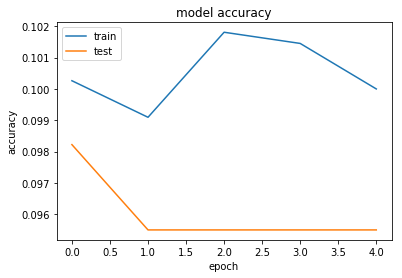

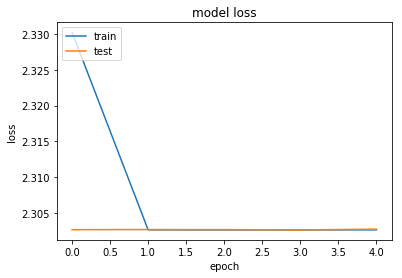

In [194]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [195]:
# predict the model
y_predict2 = dnn_model2.predict(x_test)
y_predict1D_2 = get1D_y_predict(y_predict2)

In [196]:
metrics.accuracy_score(y_test,y_predict1D_2)

0.0955

In [197]:
cr = metrics.classification_report(y_test,y_predict1D_2)
print("Classification Report: \n\n", cr)

Classification Report: 

               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1814
           1       0.00      0.00      0.00      1828
           2       0.00      0.00      0.00      1803
           3       0.10      1.00      0.17      1719
           4       0.00      0.00      0.00      1812
           5       0.00      0.00      0.00      1768
           6       0.00      0.00      0.00      1832
           7       0.00      0.00      0.00      1808
           8       0.00      0.00      0.00      1812
           9       0.00      0.00      0.00      1804

   micro avg       0.10      0.10      0.10     18000
   macro avg       0.01      0.10      0.02     18000
weighted avg       0.01      0.10      0.02     18000



C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 7. Implement batch normalization for training the neural network (2.5 points)

**Normlizing data**

In [198]:
x_train_std = x_train.astype('float32')
x_test_std = x_test.astype('float32')

#Normalizing the input
x_train_std /= 255.0
x_test_std /= 255.0

print('x_train shape:', x_train_std.shape)
print('x_test shape:', x_test_std.shape)

x_train shape: (42000, 32, 32, 1)
x_test shape: (18000, 32, 32, 1)


***Build the Graph***: Initialize model, reshape & normalize data

In [199]:
#Initialize Sequential model
dnn_model3 = keras.models.Sequential()

#Reshape data from 2D to 1D -> 32x32 to 1024
dnn_model3.add(keras.layers.Reshape((img_rows*img_cols,),input_shape=input_shape))

#Normalize the data
dnn_model3.add(keras.layers.BatchNormalization())

#Hidden layers
dnn_model3.add(keras.layers.Dense(6, activation='relu', name='Layer_1'))
dnn_model3.add(keras.layers.Dense(6, activation='relu', name='Layer_2'))
dnn_model3.add(keras.layers.Dense(6, activation='relu', name='Layer_3'))

# Output layer
#Add Dense Layer with 10 neurons as we have 10 classes after applying softmax
# Keras declares weights and bias automatically
dnn_model3.add(keras.layers.Dense(num_classes, activation='softmax'))

***Compile model***

In [200]:
#To use SGD optimizer for learning weights with learning rate = 0.001
# All parameter gradients will be clipped to
# a maximum value of 0.5 and
# a minimum value of -0.5.
optimizer = keras.optimizers.SGD(lr=0.001, clipvalue=0.5)

#compile the model --> backpropagation -> gradient descent
#optimizer = algorithm to find the optimal set of weights in ANN
#loss = functions that should be optimized.
#metrics = criterion used to calculate the performance of the model.
dnn_model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

***Review model***

In [201]:
dnn_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
Layer_1 (Dense)              (None, 6)                 6150      
_________________________________________________________________
Layer_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
Layer_3 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                70        
Total params: 10,400
Trainable params: 8,352
Non-trainable params: 2,048
_________________________________________________________________


***Train the model***

In [171]:
# Execute the model
#batch_size = the number of observations after which you want to update the weights
#           batch size and epochs should be tuned through experiments.
#epoch = going through the whole dataset
history = dnn_model3.fit(x_train_std, y_train_cat, 
          validation_data=(x_test_std, y_test_cat), 
          epochs=20,
          batch_size=32)

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 9s 203us/step - loss: 2.3053 - acc: 0.1071 - val_loss: 2.2991 - val_acc: 0.1158
Epoch 2/20
42000/42000 [==============================] - 6s 151us/step - loss: 2.2945 - acc: 0.1195 - val_loss: 2.2866 - val_acc: 0.1312
Epoch 3/20
42000/42000 [==============================] - 6s 149us/step - loss: 2.2799 - acc: 0.1353 - val_loss: 2.2668 - val_acc: 0.1471
Epoch 4/20
42000/42000 [==============================] - 6s 151us/step - loss: 2.2582 - acc: 0.1514 - val_loss: 2.2388 - val_acc: 0.1657
Epoch 5/20
42000/42000 [==============================] - 6s 151us/step - loss: 2.2285 - acc: 0.1711 - val_loss: 2.2048 - val_acc: 0.1816
Epoch 6/20
42000/42000 [==============================] - 6s 150us/step - loss: 2.1970 - acc: 0.1834 - val_loss: 2.1694 - val_acc: 0.2008
Epoch 7/20
42000/42000 [==============================] - 6s 152us/step - loss: 2.1655 - acc: 0.1955 - val_loss: 2.1378 - 

In [172]:
dnn_model3_test_loss, dnn_model3_test_acc = dnn_model3.evaluate(x_test_std, y_test_cat)
print('\nDNN Test accuracy:[With Batch Normalization]: %0.2f' %(dnn_model3_test_acc*100))

18000/18000 [==============================] - 1s 68us/step

DNN Test accuracy:[With Batch Normalization]: 28.82


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


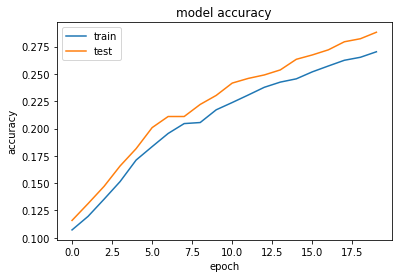

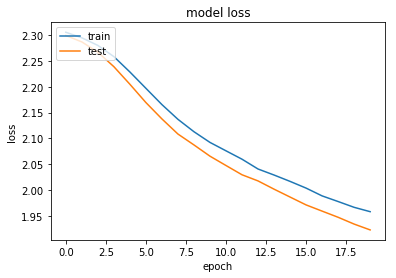

In [173]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [174]:
# predict the model
y_predict_3 = dnn_model3.predict(x_test)
y_predict1D_3 = get1D_y_predict(y_predict_3)
metrics.accuracy_score(y_test,y_predict1D_3)

0.2644444444444444

In [175]:
cr = metrics.classification_report(y_test,y_predict1D_3)
print("Classification Report: \n\n", cr)

Classification Report: 

               precision    recall  f1-score   support

           0       0.19      0.73      0.30      1814
           1       0.49      0.32      0.39      1828
           2       0.36      0.25      0.29      1803
           3       0.25      0.00      0.00      1719
           4       0.39      0.43      0.41      1812
           5       0.00      0.00      0.00      1768
           6       0.00      0.00      0.00      1832
           7       0.26      0.66      0.37      1808
           8       0.23      0.23      0.23      1812
           9       0.00      0.00      0.00      1804

   micro avg       0.26      0.26      0.26     18000
   macro avg       0.22      0.26      0.20     18000
weighted avg       0.22      0.26      0.20     18000



C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Building the CNN

***Normalizing the input***

In [202]:
x_train_std = x_train.astype('float32')
x_test_std = x_test.astype('float32')

#Normalizing the input
x_train_std /= 255.0
x_test_std /= 255.0

print('x_train shape:', x_train_std.shape)
print('x_test shape:', x_test_std.shape)

x_train shape: (42000, 32, 32, 1)
x_test shape: (18000, 32, 32, 1)


***Define the layers of model***

In [203]:
#Initialize the model
cnn_model = Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))

#Add a MaxPooling Layer of size 2X2 
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

#Apply Dropout with 0.25 probability 
cnn_model.add(Dropout(0.25))

#Flatten the layer
cnn_model.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
cnn_model.add(Dense(128, activation='relu'))

#Apply Dropout with 0.5 probability 
cnn_model.add(Dropout(0.5))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
cnn_model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


***Build the model by setting Optimizer and Loss function for training***

In [204]:
#To use adam optimizer for learning weights with learning rate = 0.001
optimizer = keras.optimizers.Adam(lr=0.001)

#Set the loss function and optimizer for the model training
cnn_model.compile(loss=categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

***Review Model***

In [205]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               1605760   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

***Initializing Early stopping and Model chekpoint callbacks***

In [206]:
# use tensorboard callback which will passed in model.fit function.

#Setting the directory to store the logs.
tensorboard = TensorBoard(log_dir=".logs/{}".format(time()))

In [207]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves 
# a new low value. Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('svhn_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

***Fit the model to the dataset***

In [208]:
#Training on the dataset and adding the all the callbacks to the fit function.
#Once the training starts, results start appearing on Tensorboard after 1 epoch
history = cnn_model.fit(x_train_std, y_train_cat,
          batch_size=16,
          epochs=50,
          verbose=1,
          validation_data=(x_test_std, y_test_cat),
          callbacks=[tensorboard,early_stopping,model_checkpoint])

Train on 42000 samples, validate on 18000 samples
Epoch 1/50
42000/42000 [==============================] - 192s 5ms/step - loss: 1.1305 - acc: 0.6238 - val_loss: 0.5956 - val_acc: 0.8245

Epoch 00001: val_loss improved from inf to 0.59560, saving model to svhn_cnn_checkpoint_01_loss0.5956.h5
Epoch 2/50
42000/42000 [==============================] - 183s 4ms/step - loss: 0.6836 - acc: 0.7886 - val_loss: 0.4934 - val_acc: 0.8521

Epoch 00002: val_loss improved from 0.59560 to 0.49341, saving model to svhn_cnn_checkpoint_02_loss0.4934.h5
Epoch 3/50
42000/42000 [==============================] - 182s 4ms/step - loss: 0.6007 - acc: 0.8116 - val_loss: 0.4372 - val_acc: 0.8708

Epoch 00003: val_loss improved from 0.49341 to 0.43723, saving model to svhn_cnn_checkpoint_03_loss0.4372.h5
Epoch 4/50
42000/42000 [==============================] - 183s 4ms/step - loss: 0.5586 - acc: 0.8258 - val_loss: 0.4227 - val_acc: 0.8774

Epoch 00004: val_loss improved from 0.43723 to 0.42273, saving model to

In [209]:
cnn_model_test_loss, cnn_model_test_acc = cnn_model.evaluate(x_test_std, y_test_cat)
print('\nCNN Test accuracy: %0.2f' %(cnn_model_test_acc*100))

18000/18000 [==============================] - 13s 700us/step

CNN Test accuracy: 90.62


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


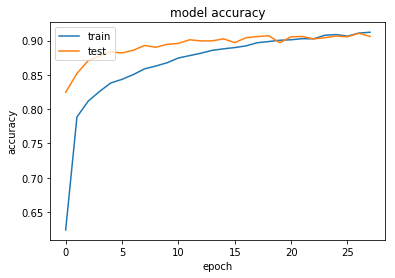

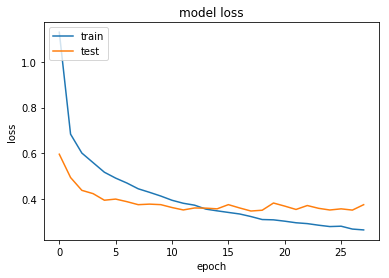

In [210]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [211]:
# predict the model
y_predict_4 = cnn_model.predict(x_test_std)
y_predict1D_4 = get1D_y_predict(y_predict_4)
metrics.accuracy_score(y_test,y_predict1D_4)

0.9061666666666667

In [212]:
cr = metrics.classification_report(y_test,y_predict1D_4)
print("Classification Report: \n\n", cr)

Classification Report: 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1814
           1       0.87      0.92      0.90      1828
           2       0.92      0.93      0.93      1803
           3       0.90      0.87      0.88      1719
           4       0.92      0.91      0.91      1812
           5       0.91      0.89      0.90      1768
           6       0.89      0.89      0.89      1832
           7       0.93      0.92      0.93      1808
           8       0.87      0.90      0.89      1812
           9       0.92      0.88      0.90      1804

   micro avg       0.91      0.91      0.91     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.91      0.91      0.91     18000



***Save the mode***: Save the trained weights and model in h5 files

In [213]:
# Save model and weights. 
cnn_model.save('model/cnn_svhn.h5')
cnn_model.save_weights('model/cnn_svhn_weights.h5')

### 8. Understand the differences and trade-offs between traditional and NN classifiers with the help of classification metrics (5 points) 

**Compare Test accuracy for all models**

In [275]:
print("Iteration    Model                  Model Summary                                                            Test Accuracy")
print("---------    -----                  -------------                                                            -------------\n")
print("Iteration-1: KNN   Summary: k=5, without data normalization                                                 %0.2f" %(knn_test_acc1*100))
print("Iteration-2: KNN   Summary: k=5, with data normalization                                                    %0.2f" %(knn_test_acc2*100))
print("Iteration-3: DNN   RELU activation, hidden layers, loss=adam, without data/batch normalization              %0.2f" %(dnn_model1_test_acc*100))
print("Iteration-4: DNN   RELU activation, hidden layers, loss=SGD, without data/batch normalization               %0.2f" %(dnn_model2_test_acc*100))
print("Iteration-5: DNN   RELU activation, hidden layers, loss=SGD, with batch normalization                       %0.2f" %(dnn_model3_test_acc*100))
print("Iteration-6: CNN   Convolution layer, Max Pooling, Dropout, Hidden layer, with data and batch normalization %0.2f" %(cnn_model_test_acc*100))

Iteration    Model                  Model Summary                                                            Test Accuracy
---------    -----                  -------------                                                            -------------

Iteration-1: KNN   Summary: k=5, without data normalization                                                 49.02
Iteration-2: KNN   Summary: k=5, with data normalization                                                    49.02
Iteration-3: DNN   RELU activation, hidden layers, loss=adam, without data/batch normalization              9.55
Iteration-4: DNN   RELU activation, hidden layers, loss=SGD, without data/batch normalization               9.55
Iteration-5: DNN   RELU activation, hidden layers, loss=SGD, with batch normalization                       28.82
Iteration-6: CNN   Convolution layer, Max Pooling, Dropout, Hidden layer, with data and batch normalization 90.62


<h2> Analysis report for experiment done on SVHN dataset using KNN and NN Classifier</h2>

**EDA**
1. few images were visualized and obsered that model face challenges becauses of many reason as below.
2. few image are blurred
3. few images have black backgrouhg while other are in white backgrounds
4. In few images, digits are accompained with other digits on the side

**Experiments:**
Various models were build using KNN, NN and CNN. Classification metric were reported for each model for comparision.
Recall and precision for each class were analysis for model comparisions.
For NN and CNN, history were plot to view the trend of train and test loss for each epoc.

<h3>KNN Clasifier</h3>

**Iteration-1:** KNN model is build without any data normalization

1. Overall test accuracy acheived is 49%
2. Digit 4 and 7 able to acheive better Precission and recall value
3. Digit 7 got highest precision of 72% but recall value is 58%
4. Digit 1 got highest recall of 70%  abut precision is quite low 44%

**Iteration-2:** KNN model is build post data normalization

1. Accuracy does not improvy after aplying data normalization, accuracy is 49%
2. recall and precision of each class almost same as for iteration-1

<h3>Various attempts were made to build Neural Network as below</h3>

**Iteration-1: Feed Forward with RELU activation function**

1. Overall test accuracy acheived is approx 10% 
2. Model is highly overfit
2. Modle was build without any data normalization, optimizer='adam', loss='categorical_crossentropy
3. Recall of digit=3 is 100% but precision is 10%..not able to classifiy and predict any other digits. Recall and precision ofr remaining digits is zero
4. this model is highly overfit

**Iteration-2: Back propagation with SGD optimizer(without data normalization and no batch normalization**

1. Even after applying optimizer as SGD, model accuracy didn't improved.  acheived is still approx 10% 
2. Recall of digit=3 is 100% but precision is 10%..not able to classifiy and predict any other digits. Recall and precision ofr remaining digits is zero, this model is highly overfit2. 
3. Modle was build without any data normalization, customized optimizer for SGD, loss='categorical_crossentropy
4. Executed with epochs=5, batch_size=16
5. this model is highly overfit

**Iteration-3: Back propagation with SGD optimizer(with input data normalization and batch normalization**

1. Overall test accuracy improved and acheived 28% accuracy 
2. Model was build with input data normalization, batch normalization, customized optimizer for SGD loss='categorical_crossentropy
3. Executed with epochs=20, batch_size=16
4. For digit=5,6 and 9, recall and precission are zero. model is not able to classify these images.
5. For digit=3, precision is 25% but recall is zero, mean modle is not bale to classify the class(3) correctly at all.

**Iteration-4: Experiment with CNN**

1. Overall test accuracy improved significantly and acheived around 90% accuracy 
2. Model was build with Convolution layer, Max pooling, Dropout, Hidden layer and applied input data normalization, batch normalization, customized optimizer for SGD loss='categorical_crossentropy
3. Executed with epochs=50, batch_size=16
4. Acheived better recall and precision for all classes above 87% and given better result than any other model experiment her.

Finally plotted Train and Test accuracy for each epoc to verify if model does not overfit for all experiments

Also it is observed for image type of dataset, KNN demand heavy computational load compared to NN/CNN network
